In [1]:
# 02_evaluate_bf_diffusion_posterior.py

import sys
import os
import keras
import numpy as np
import bayesflow as bf
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "keras"

# ------------------------------------------------------------------
# Add project paths
# ------------------------------------------------------------------
DATA_PATH = r"C:\Users\arnab\OneDrive\Desktop\Study material\Research\tearfilm_diffusion_sbi\Intensity to c_max\src\data"
BF_PATH   = r"C:\Users\arnab\OneDrive\Desktop\Study material\Research\tearfilm_diffusion_sbi\Intensity to c_max\src\bf"

sys.path.append(DATA_PATH)
sys.path.append(BF_PATH)

# ------------------------------------------------------------------
# Import your existing scripts
# ------------------------------------------------------------------
from h5_dataset_c_max import load_dataset
from data_split import split_dataset
from theta_transform import theta_transform
from noise_model import add_multiplicative_noise

np.random.seed(0)

from make_workflow import make_workflow


# ------------------------------------------------------------------
# 1. Load dataset
# ------------------------------------------------------------------

splits = split_dataset(load_dataset(downsample_to=101), train_frac=0.7, test_frac=0.2, val_frac=0.1, shuffle=True, seed=42)

I_train, c_max_train = splits[0]
I_test, c_max_test = splits[1]
I_val, c_max_val = splits[2]

I_train_clean, c_max_tilde_train, mu_train, s_train = theta_transform((I_train, c_max_train))
x_train, c_max_tilde_train = add_multiplicative_noise(
    (I_train_clean, c_max_tilde_train),
    noise_std=0.01,
    seed=123
)

x_test, c_max_test = add_multiplicative_noise(
    (I_test, c_max_test),
    noise_std=0.01,
    seed=456
)

c_max_tilde_test = (c_max_test - mu_train) / s_train  # standardize test c_max using train mu and s

x_val, c_max_val = add_multiplicative_noise(
    (I_val, c_max_val),
    noise_std=0.01,
    seed=789
)

c_max_tilde_val = (c_max_val - mu_train) / s_train  # standardize val c_max using train mu and s

train_dict = {"x": x_train, "c_max": c_max_tilde_train}
test_dict = {"x": x_test, "c_max": c_max_tilde_test}
val_dict = {"x": x_val, "c_max": c_max_tilde_val}


# ------------------------------------------------------------------
# 2. Create diffusion model + workflow
# ------------------------------------------------------------------
diffnet, workflow = make_workflow(
    widths=(512, 1024, 2048, 2048, 1024, 512, 256),
    time_embedding_dim=128,
    diffusion_steps=1000,
)


# ------------------------------------------------------------------
# 3. Override learning rate (simple control)
# ------------------------------------------------------------------
# workflow.optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# ------------------------------------------------------------------
# 3. Load trained model weights
# ------------------------------------------------------------------
model_path = r"C:\Users\arnab\OneDrive\Desktop\Study material\Research\tearfilm_diffusion_sbi\Intensity to c_max\checkpoints\tearfilm_sbi_diffusion_c_max.keras"
train_after_load = False  # Set to True if you want to continue training after loading the model

if not os.path.exists(model_path):
    print(f"Model file not found at {model_path}. Training a new model...")
    _ = workflow.fit_offline(
        train_dict,
        validation_data=val_dict,
        epochs=20,
        batch_size=256,
        verbose=2,
    )
    workflow.approximator.save(model_path)
elif train_after_load:
    print(f"Model file found at {model_path}. Loading model and continuing training...")
    workflow.approximator = keras.models.load_model(model_path)
    _ = workflow.fit_offline(
        train_dict,
        validation_data=val_dict,
        epochs=2,
        batch_size=256,
        verbose=2,
    )
    workflow.approximator.save(model_path)
else:
    print(f"Model file found at {model_path}. Loading model without further training...")
    workflow.approximator = keras.models.load_model(model_path)

INFO:2026-02-27 18:39:36,752:jax._src.xla_bridge:834: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:bayesflow:Using backend 'jax'
c:\Users\arnab\anaconda3\envs\diffexp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Model file not found at C:\Users\arnab\OneDrive\Desktop\Study material\Research\tearfilm_diffusion_sbi\Intensity to c_max\checkpoints\tearfilm_sbi_diffusion_c_max.keras. Training a new model...
Epoch 1/20
177/177 - 25s - 140ms/step - loss: 0.3478 - val_loss: 0.1489
Epoch 2/20
177/177 - 20s - 115ms/step - loss: 0.1566 - val_loss: 0.1072
Epoch 3/20
177/177 - 20s - 112ms/step - loss: 0.1245 - val_loss: 0.1145
Epoch 4/20
177/177 - 20s - 115ms/step - loss: 0.1113 - val_loss: 0.0999
Epoch 5/20
177/177 - 20s - 115ms/step - loss: 0.1012 - val_loss: 0.1077
Epoch 6/20
177/177 - 20s - 113ms/step - loss: 0.1026 - val_loss: 0.0854
Epoch 7/20
177/177 - 20s - 114ms/step - loss: 0.0918 - val_loss: 0.0815
Epoch 8/20
177/177 - 21s - 116ms/step - loss: 0.0906 - val_loss: 0.0821
Epoch 9/20
177/177 - 21s - 116ms/step - loss: 0.0865 - val_loss: 0.0836
Epoch 10/20
177/177 - 21s - 116ms/step - loss: 0.0878 - val_loss: 0.0815
Epoch 11/20
177/177 - 21s - 117ms/step - loss: 0.0791 - val_loss: 0.0830
Epoch 12/20


INFO:bayesflow:Training completed in 6.98 minutes.


Sampling:   0%|          | 0/7 [00:00<?, ?batch/s]

Sampling: 100%|██████████| 7/7 [24:03<00:00, 206.21s/batch]
C:\Users\arnab\AppData\Local\Temp\ipykernel_10616\2888788247.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


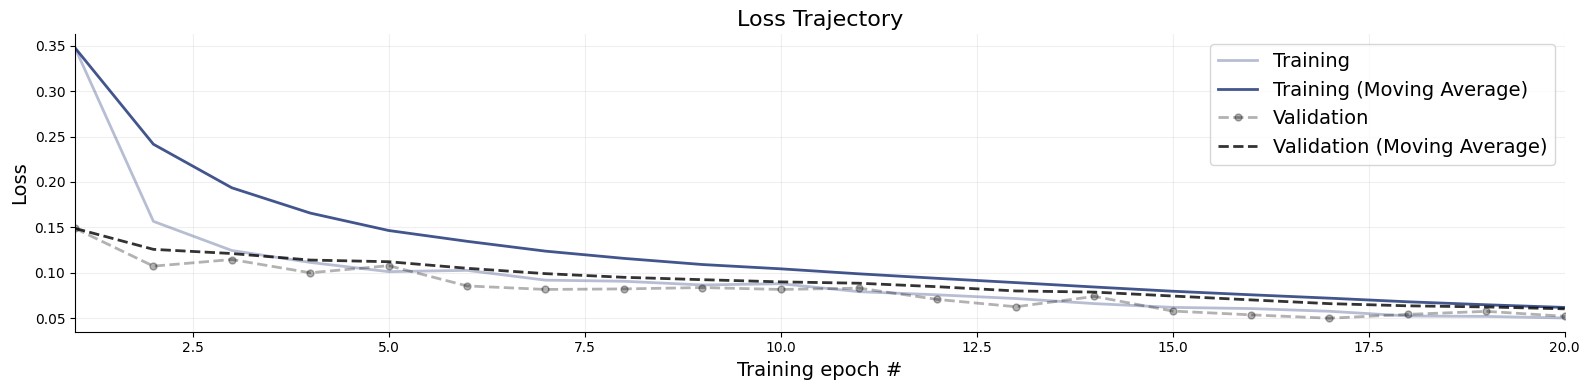

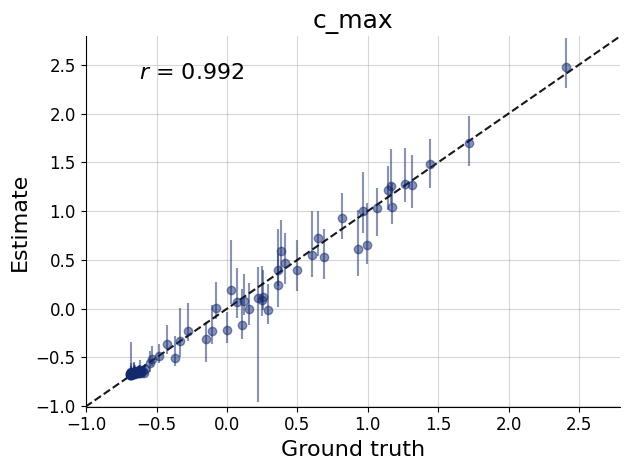

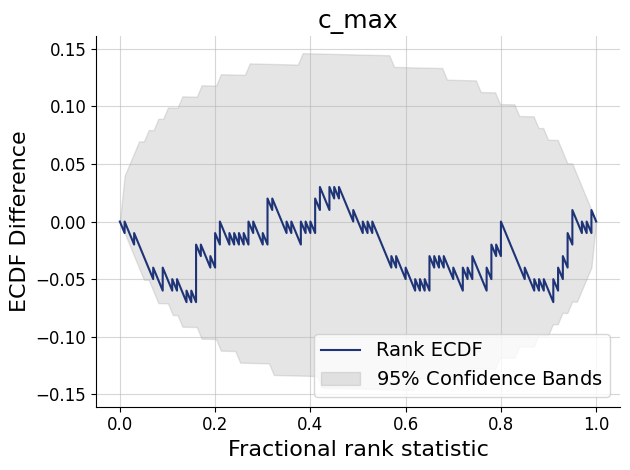

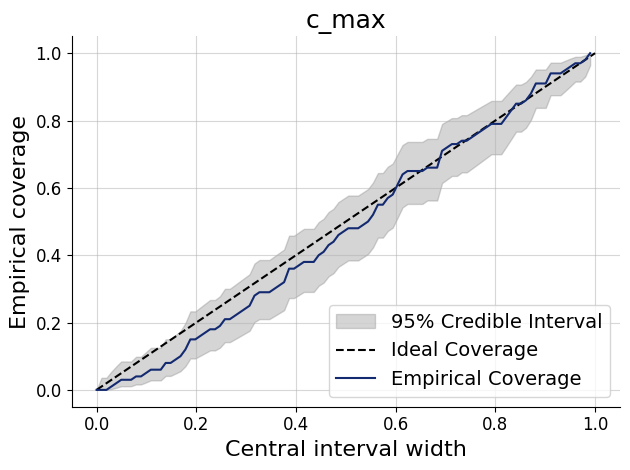

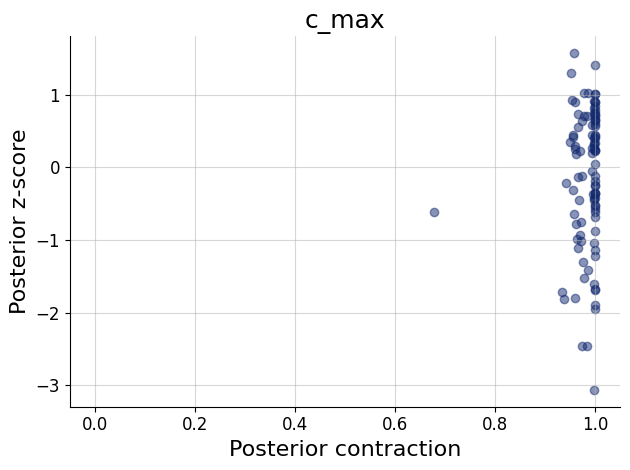

In [2]:
# randomly pick 100 examples from the test set
num_samples = 100
idx = np.random.choice(len(test_dict["x"]), size=num_samples, replace=False)
test_dict_small = {"x": test_dict["x"][idx], "c_max": test_dict["c_max"][idx]}

test_data = workflow.adapter(test_dict_small)
test_data["c_max"] = test_data["inference_variables"]
# (test_data["x"], test_data["theta_condition"]) = test_data["inference_conditions"]


figs = workflow.plot_default_diagnostics(
    test_data=test_data,
    num_samples=100,
    approximator_kwargs={"batch_size": 16},   # try 64/32/16/8
)
for fig in figs.values():
    fig.show()